In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
import h5py
from astropy.table import Table
from batman import TransitParams, TransitModel
from astropy.stats import mad_std

In [2]:
koi_table = Table.read('data/cumulative_2019.07.05_01.52.59.votable')
koi_table.add_index('kepid')

In [3]:
import sys
sys.path.insert(0, '../TESSellate/')
from toolkit import LightCurve
from astropy.time import Time

In [4]:
from astropy.constants import R_earth, R_sun


In [82]:
archive = h5py.File('data/kepler_lcs/archive.hdf5', 'r')

kepids = []
scatter_ratio = []

for kepid in list(archive): 
    if kepid != '001026895' and kepid != '004165496' and kepid != '010676011':  # bad file
        bstr = str(int(kepid)).encode()
        props = koi_table.loc[bstr]
        
        if not isinstance(koi_table.loc[bstr]['kepid'], bytes): 
            props = props[np.argmax(props['koi_depth'])]
        
        period = props['koi_period']
        duration = props['koi_duration'] / 24

        epoch = props['koi_time0bk'] + 2454833 #+ 0.5*duration
        b = props['koi_impact']
        
        params = TransitParams()
        params.per = period
        params.t0 = epoch
        params.duration = duration
        params.rp = float(props['koi_prad']*R_earth/(props['koi_srad']*R_sun)) #(props['koi_depth'] * 1e-6)**0.5
        
        a = (np.sin(duration * np.pi / period) / np.sqrt((1 + params.rp)**2 - b**2))**-1

        params.a = a
        params.inc = np.degrees(np.arccos(b / params.a))
        params.w = 90
        params.ecc = 0
        params.limb_dark = 'quadratic'
        params.u = [0.5079, 0.2239]
                
        t, f = archive[kepid][:]
        sort = np.argsort(t)
        
        t = Time(t[sort], format='jd')
        f = f[sort]

        lc = LightCurve(t, f)
        packed = lc.mask_out_of_transit(params, oot_duration_fraction=1.5)

        if len(packed['times']) > 0:
            transits = LightCurve(**packed).get_transit_light_curves(params)
            in_transit_fluxes = []
            out_of_transit_fluxes = []
            if len(transits) > 0:                 
                for transit in transits: 
                    transit.remove_polynomial_baseline(params, order=2)
#                     transit.plot(params, phase=True, show=False, 
#                                  plot_kwargs=dict(lw=0, marker=',', ms=10, alpha=0.1, color='k'))
#                 plt.show()
                    transit.fluxes /= TransitModel(params, transit.times.jd).light_curve(params)
#                     transit.plot(params, phase=True, show=False, 
#                                  plot_kwargs=dict(lw=0, marker=',', ms=10, alpha=0.1, color='k'))
                    phases = transit.phases(params)
                    in_transit = np.abs(phases) < 0.4*params.duration/params.per 
                    out_of_transit = np.abs(phases) > 0.6*params.duration/params.per
            
                    in_transit_fluxes.append(transit.fluxes[in_transit])
                    out_of_transit_fluxes.append(transit.fluxes[out_of_transit])
            
#                     plt.plot(phases[in_transit], transit.fluxes[in_transit], ',', color='r', alpha=0.1)
#                     plt.plot(phases[out_of_transit], transit.fluxes[out_of_transit], ',', color='k', alpha=0.1)
                kepids.append(kepid)
                ratio = mad_std(np.concatenate(in_transit_fluxes)) / mad_std(np.concatenate(out_of_transit_fluxes))
#                 print(ratio)
                scatter_ratio.append(ratio)

            plt.show()

../TESSellate/toolkit/lightcurve.py:603: RankWarning: Polyfit may be poorly conditioned
  self.fluxes[mask][~near_transit], order)


In [71]:
import pandas as pd

df = pd.DataFrame(scatter_ratio, index=kepids, columns=['ratio'])
df = df.sort_values('ratio')

Text(0, 0.5, 'KIC')

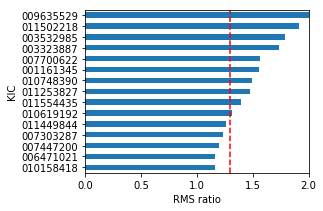

In [83]:
fig, ax = plt.subplots(figsize=(4, 3))
df[-15:].plot(kind='barh', legend=False, ax=ax)
plt.axvline(1.3, color='r', ls='--')
plt.xlim([0, 2])
plt.xlabel('RMS ratio')
plt.ylabel('KIC')

Kepler-17 b / 010619192


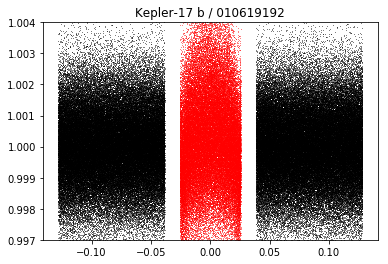

Kepler-63 b / 011554435


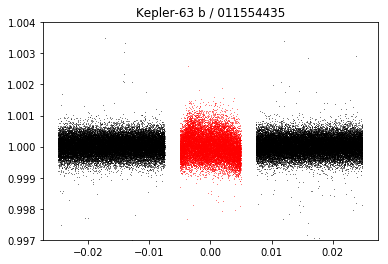

Kepler-396 c / 011253827


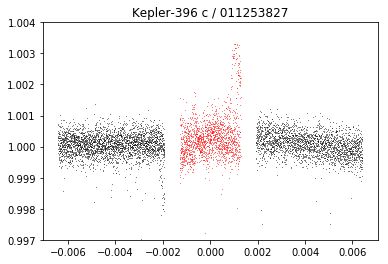

Kepler-3 b / 010748390


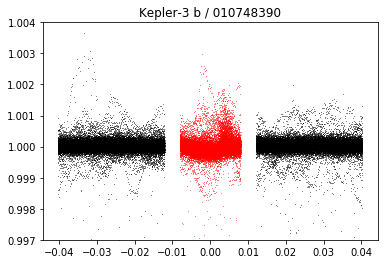

 / 001161345


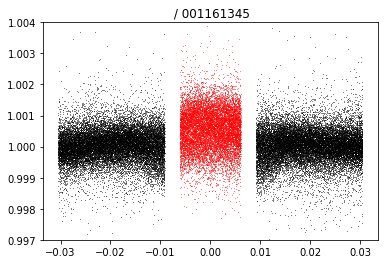

 / 007700622


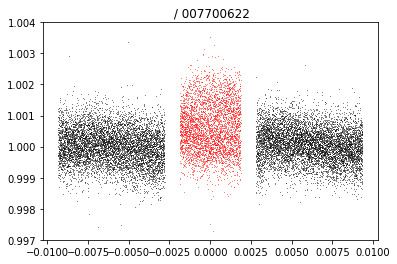

Kepler-9 b / 003323887


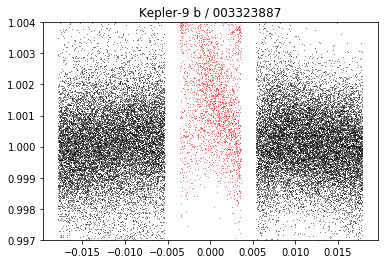

 / 003532985


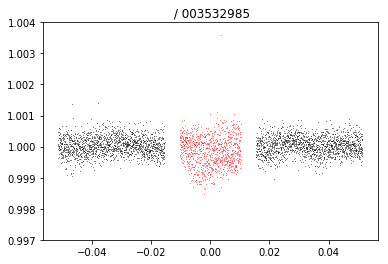

 / 011502218


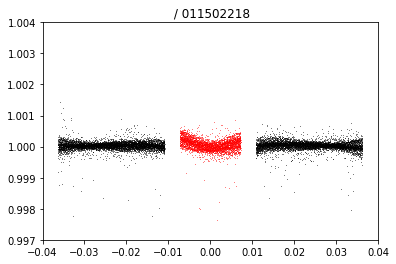

In [84]:
for kepid in df.index[df.values[:, 0] > 1.3]: 
    if kepid != '001026895' and kepid != '004165496' and kepid != '010676011' and kepid != '009635529':  # bad file
        bstr = str(int(kepid)).encode()
        props = koi_table.loc[bstr]
        
        if not isinstance(koi_table.loc[bstr]['kepid'], bytes): 
            props = props[np.argmax(props['koi_depth'])]
        
        period = props['koi_period']
        duration = props['koi_duration'] / 24

        epoch = props['koi_time0bk'] + 2454833 
        b = props['koi_impact']
        
        params = TransitParams()
        params.per = period
        params.t0 = epoch
        params.duration = duration
        params.rp = float(props['koi_prad']*R_earth/(props['koi_srad']*R_sun)) #(props['koi_depth'] * 1e-6)**0.5
        
        a = (np.sin(duration * np.pi / period) / np.sqrt((1 + params.rp)**2 - b**2))**-1

        params.a = a
        params.inc = np.degrees(np.arccos(b / params.a))
        params.w = 90
        params.ecc = 0
        params.limb_dark = 'quadratic'
        params.u = [0.5079, 0.2239]
                
        t, f = archive[kepid][:]
        sort = np.argsort(t)
        
        t = Time(t[sort], format='jd')
        f = f[sort]

        lc = LightCurve(t, f)
        packed = lc.mask_out_of_transit(params, oot_duration_fraction=1.5)

        if len(packed['times']) > 0:
            transits = LightCurve(**packed).get_transit_light_curves(params)
            print(props['kepler_name'].decode() + ' / ' + kepid)

            in_transit_fluxes = []
            out_of_transit_fluxes = []
            if len(transits) > 0:                 
                for transit in transits: 
                    transit.remove_polynomial_baseline(params, order=2)
                    transit.fluxes /= TransitModel(params, transit.times.jd).light_curve(params)
#                     transit.plot(params, phase=True, show=False, 
#                                  plot_kwargs=dict(lw=0, marker=',', ms=10, alpha=0.1, color='k'))
                    phases = transit.phases(params)
                    in_transit = np.abs(phases) < 0.4*params.duration/params.per 
                    out_of_transit = np.abs(phases) > 0.6*params.duration/params.per
            
                    in_transit_fluxes.append(transit.fluxes[in_transit])
                    out_of_transit_fluxes.append(transit.fluxes[out_of_transit])
#                     plt.title()
                    plt.title(props['kepler_name'].decode() + ' / ' + kepid)
                    plt.plot(phases[in_transit], transit.fluxes[in_transit], ',', color='r', alpha=0.5)
                    plt.plot(phases[out_of_transit], transit.fluxes[out_of_transit], ',', color='k', alpha=0.5)
            plt.ylim([0.997, 1.004])
            plt.show()

In [85]:
np.save('data/spot_searched.npy', np.vstack([kepids, scatter_ratio]))